# Unsupervised Wisdom: Explore Medical Narratives on Older Adult Falls

    Project Outline

1. Problem Description
2. Introduction to Approach Used
3. Data Cleaning and Preprocessing
4. Exploratory Data Analysis and Data Visualization
5. Model Building
6. Final Inference

---

## 3. Data Cleaning and Preprocessing

##### Import required modules

In [1]:
import numpy as np
import pandas as pd

import json

import re

##### Load the data

In [2]:
data = pd.read_csv("data/primary_data.csv")

#Display an overview of the data
data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,1,0,NaN,0,62,NaN,...,75,NaN,4,5,0,0,0,1807,0,0
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,1,0,NaN,0,62,NaN,...,75,NaN,4,1,0,0,0,611,0,0
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,2,0,NaN,0,53,NaN,...,32,NaN,4,1,0,0,0,679,1807,0


In [3]:
rows, columns = data.shape
print(f'The data contains {rows:,} rows and {columns} columns')

The data contains 115,128 rows and 22 columns


##### Check for null values

In [4]:
#Only display columns with null values
null = data.isnull().sum()

null[null != 0]

other_race           114106
other_diagnosis      112606
diagnosis_2           71983
other_diagnosis_2    110150
body_part_2           71983
dtype: int64

There are null values present, but only occur in fields that are optional. So, they can be left without having to perform any operation on them

##### Check for duplicates

In [5]:
data.duplicated().sum()

0

This shows there are no duplicate values for each person-event pairings.   
Though, a person can have more than one record due to different fall events, but will result in different case numbers; thereby each recorded fall remains unique.

##### Variable Mapping

From the data, it shows that some columns like sex, race, e.t.c. have numeric values which can be decoded to their respective strings.   
The data is redisplayed below for easier reference

In [6]:
data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,1,0,NaN,0,62,NaN,...,75,NaN,4,5,0,0,0,1807,0,0
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,1,0,NaN,0,62,NaN,...,75,NaN,4,1,0,0,0,611,0,0
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,2,0,NaN,0,53,NaN,...,32,NaN,4,1,0,0,0,679,1807,0


In [7]:
#Load the variable mapping file
with open('data/variable_mapping.json', 'r') as f:
    mapping = json.load(f, parse_int=True)

In [8]:
#Overview of the variable mapping file
mapping

{'sex': {'0': 'UNKNOWN', '1': 'MALE', '2': 'FEMALE', '3': 'NON-BINARY/OTHER'},
 'race': {'0': 'N.S.',
  '1': 'WHITE',
  '2': 'BLACK/AFRICAN AMERICAN',
  '3': 'OTHER',
  '4': 'ASIAN',
  '5': 'AMERICAN INDIAN/ALASKA NATIVE',
  '6': 'NATIVE HAWAIIAN/PACIFIC ISLANDER'},
 'hispanic': {'0': 'Unk/Not stated', '1': 'Yes', '2': 'No'},
 'alcohol': {'0': 'No/Unk', '1': 'Yes'},
 'drug': {'0': 'No/Unk', '1': 'Yes'},
 'body_part': {'0': '0 - INTERNAL',
  '30': '30 - SHOULDER',
  '31': '31 - UPPER TRUNK',
  '32': '32 - ELBOW',
  '33': '33 - LOWER ARM',
  '34': '34 - WRIST',
  '35': '35 - KNEE',
  '36': '36 - LOWER LEG',
  '37': '37 - ANKLE',
  '38': '38 - PUBIC REGION',
  '75': '75 - HEAD',
  '76': '76 - FACE',
  '77': '77 - EYEBALL',
  '78': '78 - UPPER TRUNK(OLD)',
  '79': '79 - LOWER TRUNK',
  '80': '80 - UPPER ARM',
  '81': '81 - UPPER LEG',
  '82': '82 - HAND',
  '83': '83 - FOOT',
  '84': '84 - 25-50% OF BODY',
  '85': '85 - ALL PARTS BODY',
  '86': '86 - OTHER(OLD)',
  '87': '87 - NOT STATED/U

Make corrections to the decoded variables where necessary

In [9]:
#Convert the encoded values in the mapping to integers since they get read in as strings
#such as '0' to 0
for c in mapping.keys():
    mapping[c] = {int(k): v for k, v in mapping[c].items()}
    
#Update the "N.S." in race to "Not Stated"
mapping['race'][0] = 'Not Stated'

#Update "Unk" term in the hispanic key to "Unknown/Not stated"
mapping['hispanic'][0] = 'Unknown/Not Stated'

#Update "No/Unk" in the alcohol, drug and location keys to "No/Unknown"
mapping['alcohol'][0] = 'No/Unknown'
mapping['drug'][0] = 'No/Unknown'

#Update "UNK" in the lcoation key to "UNKNOWN"
mapping['location'][0] = 'UNKNOWN'

#Update the fire_involvement keys
fire_updates = ['NO/UNKNOWN', 'FIRE DEPARTMENT', 'NO FIRE DEPARTMENT', 'UNKNOWN FIRE DEPARTMENT', 'MOTOR VEHICLE']
for key, update in enumerate(fire_updates):
    mapping['fire_involvement'][key] = update

In [10]:
#Overview of the variable mapping file after the updates
mapping

{'sex': {0: 'UNKNOWN', 1: 'MALE', 2: 'FEMALE', 3: 'NON-BINARY/OTHER'},
 'race': {0: 'Not Stated',
  1: 'WHITE',
  2: 'BLACK/AFRICAN AMERICAN',
  3: 'OTHER',
  4: 'ASIAN',
  5: 'AMERICAN INDIAN/ALASKA NATIVE',
  6: 'NATIVE HAWAIIAN/PACIFIC ISLANDER'},
 'hispanic': {0: 'Unknown/Not Stated', 1: 'Yes', 2: 'No'},
 'alcohol': {0: 'Unknown/Not Stated', 1: 'Yes'},
 'drug': {0: 'Unknown/Not Stated', 1: 'Yes'},
 'body_part': {0: '0 - INTERNAL',
  30: '30 - SHOULDER',
  31: '31 - UPPER TRUNK',
  32: '32 - ELBOW',
  33: '33 - LOWER ARM',
  34: '34 - WRIST',
  35: '35 - KNEE',
  36: '36 - LOWER LEG',
  37: '37 - ANKLE',
  38: '38 - PUBIC REGION',
  75: '75 - HEAD',
  76: '76 - FACE',
  77: '77 - EYEBALL',
  78: '78 - UPPER TRUNK(OLD)',
  79: '79 - LOWER TRUNK',
  80: '80 - UPPER ARM',
  81: '81 - UPPER LEG',
  82: '82 - HAND',
  83: '83 - FOOT',
  84: '84 - 25-50% OF BODY',
  85: '85 - ALL PARTS BODY',
  86: '86 - OTHER(OLD)',
  87: '87 - NOT STATED/UNK',
  88: '88 - MOUTH',
  89: '89 - NECK',
  90

Map the keys to a copy of the dataframe

In [11]:
decoded_data = data.copy()

#Map the keys to the new dataframe
for col in mapping.keys():
    decoded_data[col] = decoded_data[col].map(mapping[col])
    
#Ensure mappings were applied correctly by checking that the number of missing values did not change
assert (decoded_data.isnull().sum() == data.isnull().sum()).all()

In [12]:
#An overview of the new dataset with decoded values
decoded_data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/UNKNOWN,Unknown/Not Stated,Unknown/Not Stated,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,Unknown/Not Stated,Unknown/Not Stated,611 - BATHTUBS OR SHOWERS,0 - None,0 - None
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,Not Stated,NaN,Unknown/Not Stated,"53 - CONTUSIONS, ABR.",NaN,...,32 - ELBOW,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,Unknown/Not Stated,Unknown/Not Stated,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None


##### Data Preprocessing Contd.

From the recently decoded data above, the narrative column contains some redundancies, which are the age and sex which already exist in other columns.    
An example is "94YOM FELL..."

Removing these redundancies by removing any pattern similar to "94YOM "

In [13]:
decoded_data['narrative'].replace(r'^\d+\s*YO\w\s', '', regex = True, inplace = True)

In [14]:
#An overview of the dataset after recent changes
decoded_data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,FELL TO THE FLOOR AT THE NURSING HOME ONTO BAC...,2019-01-01,94,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/UNKNOWN,Unknown/Not Stated,Unknown/Not Stated,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None
1,190103270,FELL IN THE SHOWER AT HOME AND SUSTAINED A CLO...,2019-01-01,86,MALE,Not Stated,NaN,Unknown/Not Stated,62 - INTERNAL INJURY,NaN,...,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,Unknown/Not Stated,Unknown/Not Stated,611 - BATHTUBS OR SHOWERS,0 - None,0 - None
2,190103273,WAS GETTING UP FROM THE COUCH AND FELL TO THE ...,2019-01-01,87,FEMALE,Not Stated,NaN,Unknown/Not Stated,"53 - CONTUSIONS, ABR.",NaN,...,32 - ELBOW,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,Unknown/Not Stated,Unknown/Not Stated,"679 - SOFAS, COUCHES, DAVENPORTS, DIVANS OR ST...",1807 - FLOORS OR FLOORING MATERIALS,0 - None


##### Data Preprocessing Contd.

From the displayed data above, some columns still have their encoded value present in their decoded value.   
An example is "62 - INTERNAL INJURY" in the diagnosis column.

Using the first data as a reference, one can derive the columns with such disparities.

In [15]:
first = decoded_data.iloc[0]

#Only display columns that start with a pattern similar to "62 - INTERNAL INJURY"
encoded_still_present = first[first.str.match(r'^\d+\s\-\s\w+', flags = re.IGNORECASE) == True]

encoded_still_present

diagnosis                       62 - INTERNAL INJURY
body_part                                  75 - HEAD
disposition    4 - TREATED AND ADMITTED/HOSPITALIZED
product_1        1807 - FLOORS OR FLOORING MATERIALS
product_2                                   0 - None
product_3                                   0 - None
Name: 0, dtype: object

This pattern can be followed to remove redundancies like the digits and everything else leading up to the expected decoded value, in these columns


In [16]:
#Remove the redundancies for the observed columns
for column in encoded_still_present.index:
    decoded_data[column].replace(r'^\d+\s\-\s', '', regex = True, inplace = True)

In [17]:
#An overview of the dataset after changes
decoded_data.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,FELL TO THE FLOOR AT THE NURSING HOME ONTO BAC...,2019-01-01,94,MALE,Not Stated,NaN,Unknown/Not Stated,INTERNAL INJURY,NaN,...,HEAD,NaN,TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/UNKNOWN,Unknown/Not Stated,Unknown/Not Stated,FLOORS OR FLOORING MATERIALS,None,None
1,190103270,FELL IN THE SHOWER AT HOME AND SUSTAINED A CLO...,2019-01-01,86,MALE,Not Stated,NaN,Unknown/Not Stated,INTERNAL INJURY,NaN,...,HEAD,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,Unknown/Not Stated,Unknown/Not Stated,BATHTUBS OR SHOWERS,None,None
2,190103273,WAS GETTING UP FROM THE COUCH AND FELL TO THE ...,2019-01-01,87,FEMALE,Not Stated,NaN,Unknown/Not Stated,"CONTUSIONS, ABR.",NaN,...,ELBOW,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/UNKNOWN,Unknown/Not Stated,Unknown/Not Stated,"SOFAS, COUCHES, DAVENPORTS, DIVANS OR STUDIO C...",FLOORS OR FLOORING MATERIALS,None


---

## 4. Exploratory Data Analysis and Data Visualization

##### Import required modules

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

#### <pre>4.1   UNIVARIATE ANALYSIS AND VISUALIZATION </pre>

##### Age Distribution

Split the ages into age groups and visualize the age groups

In [24]:
# Defining custom age bins
age_bins = [65, 71, 77, 83, 89, 95, 101, 107, 113,]  

# Define labels for the age groups
age_labels = ['65-70', '71-76', '77-82', '83-88', '89-94', '95-100', '101-106', '107-112']

# Create a new column 'age_group' based on the custom age bins
decoded_data['age_group'] = pd.cut(decoded_data['age'], bins=age_bins, labels=age_labels)

# Display the first few rows of the DataFrame with the age groups
decoded_data[['age', 'age_group']][:5]

,age,age_group
0,94,89-94
1,86,83-88
2,87,83-88
3,67,65-70
4,70,65-70


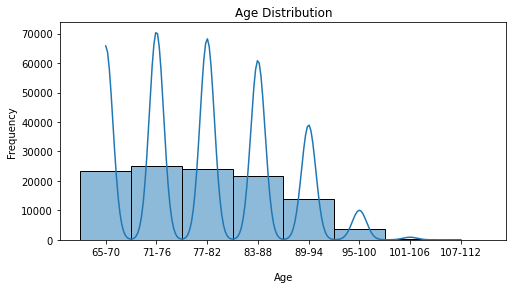

In [66]:
plt.figure(figsize=(8, 4))

sns.histplot(decoded_data['age_group'], bins = 20, kde = True)

plt.title('Age Distribution')
plt.xlabel('Age', labelpad = 15)
plt.ylabel('Frequency');

In this analysis, it becomes evident that the age distribution within the elderly population is generally between 65 to 88 years, indicating that a significant proportion of the elderly population fall within this specific range.

##### Gender Distribution

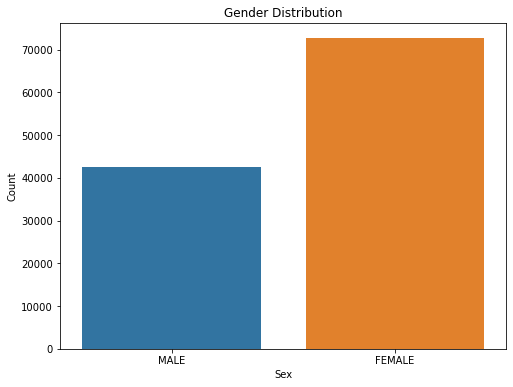

In [31]:
plt.figure(figsize=(8, 6))

sns.countplot(data = decoded_data, x = 'sex')

plt.title('Gender Distribution')
plt.xlabel('Sex')
plt.ylabel('Count');

There is a higher proportion of females than males in this dataset.

##### Race Distribution

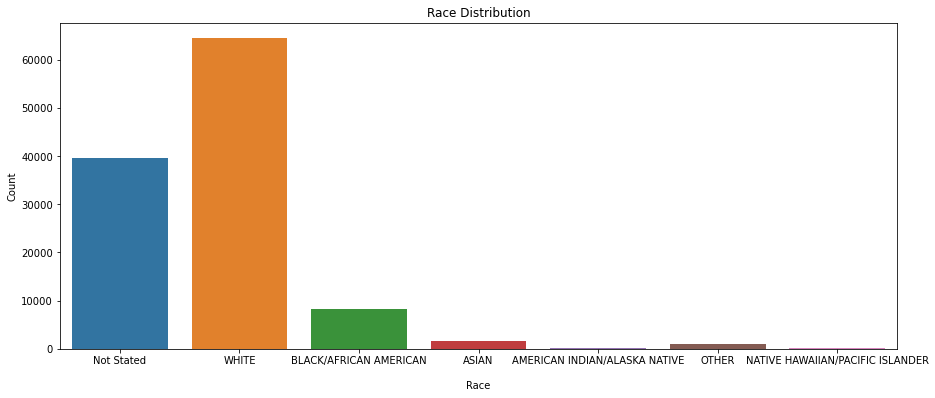

In [65]:
plt.figure(figsize=(15, 6))

sns.countplot(data = decoded_data, x = 'race')

plt.title('Race Distribution')
plt.xlabel('Race', labelpad = 15)
plt.ylabel('Count');

There is a high proportion of whites, while a considerable amount of patients' race were not available in the dataset.

##### Diagnosis Distribution

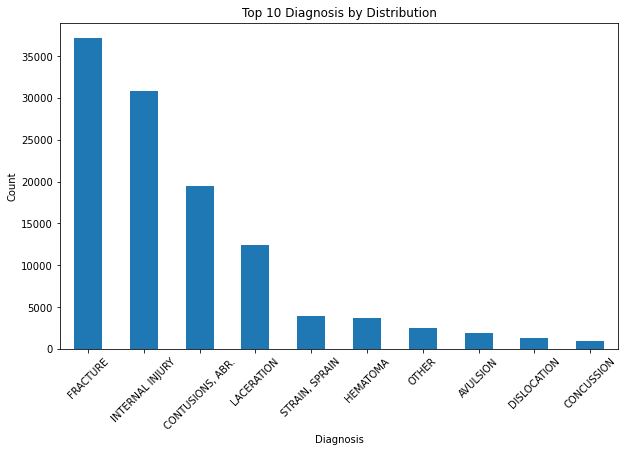

In [33]:
# Get the top 10 diagnosis 
top_10_diagnosis = decoded_data['diagnosis'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))

top_10_diagnosis.plot(kind = 'bar')

plt.title('Top 10 Diagnosis by Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.xticks(rotation=45);

These are the top 10 most frequently occurring diagnosis in this dataset, revealing the primary health conditions experienced by older individuals when they fall; with fractures being the most occuring.

##### Body Parts Distribution

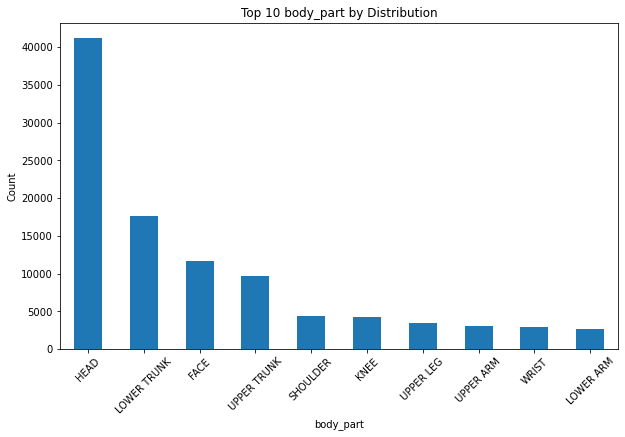

In [34]:
# Get the top 10 body parts affected by fall
top_10_body_part = decoded_data['body_part'].value_counts().head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))

top_10_body_part.plot(kind='bar')

plt.title('Top 10 body parts by Distribution')
plt.xlabel('Body part')
plt.ylabel('Count')

plt.xticks(rotation=45);

When older individuals fall, these body parts are more susceptible to being affected with the head being the most affected.

#### <pre>4.2   BIVARIATE ANALYSIS AND VISUALIZATION (with detailed insights)</pre>

This starts with analysing factors specific to individuals; like Age, Sex and Race   
Then moving on to environmental factors; specifically Location   
And then, analysing intake of substances around the duration of the fall; such as Drugs and Alcohol. 

##### Demographic Factors (Age vs Diagnosis)

In [ ]:
#Get the data that matches with the top 10 diagnosis
top_10_diagnosis = decoded_data['diagnosis'].value_counts().head(10).index
decoded_data_filtered = decoded_data[decoded_data['diagnosis'].isin(top_10_diagnosis)]

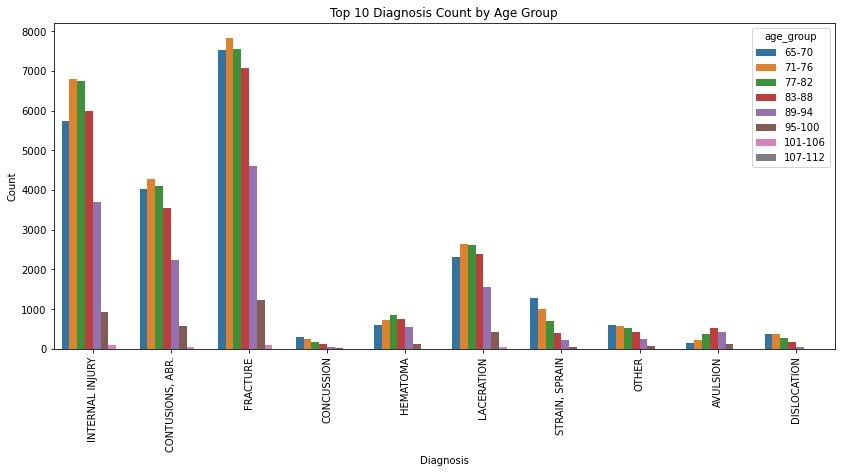

In [49]:
#Plot the data
plt.figure(figsize=(14, 6))

sns.countplot(data = decoded_data_filtered, x = 'diagnosis', hue = 'age_group')

plt.title('Top 10 Diagnosis Count by Age Group')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.xticks(rotation=90);

- ##### Insights on age-related injury trends: 

The data reveals clear age-related patterns in the types of injuries diagnosed after falls. As individuals advance in age, they exhibit distinct injury patterns, highlighting the importance of age as a risk factor for certain types of injuries.

Increased Risk of Internal Injuries (Ages 71-82): The finding that people between the ages of 71 and 82 are more frequently diagnosed with internal injuries following falls suggests that this age group may be particularly susceptible to injuries affecting internal organs. This vulnerability might be linked to age-related physiological changes or underlying health conditions.

Contusions and Auditory Brainstem Response (ABR) in Older Age Groups (Ages 65-82): The higher incidence of contusions (bruises) and the presence of auditory brainstem response (ABR) diagnoses within the age range of 65 to 82 indicate that falls in this age group not only result in physical injuries but may also have neurological or auditory implications. This finding underscores the need for a holistic assessment of falls in older adults.

Elevated Fracture Rates (Ages 65-88): The significant prevalence of fractures among individuals aged 65 to 88, with a notably higher rate, underscores the heightened risk of bone fractures in older age. This increased susceptibility might be attributed to factors such as reduced bone density and diminished musculoskeletal strength, which amplify the risk of fractures during falls.

##### Gender Factors (Sex vs Diagnosis)

This compares the genders against the top three diagnosis

In [40]:
#Get the data that matches with the top 3 diagnosis
top_3_diagnosis = decoded_data['diagnosis'].value_counts().head(3).index
decoded_data_filtered_2 = decoded_data[decoded_data['diagnosis'].isin(top_3_diagnosis)]

Create the data for a percentage stacked bar chart

In [41]:
# Calculate the proportions of each diagnosis by gender
diagnosis_by_sex = decoded_data_filtered_2.groupby(['sex', 'diagnosis']).size() / decoded_data_filtered_2.groupby('sex').size()

# Reset the index for the proportions
diagnosis_by_sex = diagnosis_by_sex.reset_index(name = 'Proportion')

# Pivot the data to create a percentage stacked bar chart
pivot_table = diagnosis_proportions.pivot(index = 'sex', columns = 'diagnosis', values = 'Proportion')

# Normalize the data to percentages (multiply by 100)
pivot_table *= 100

Plot the visualization

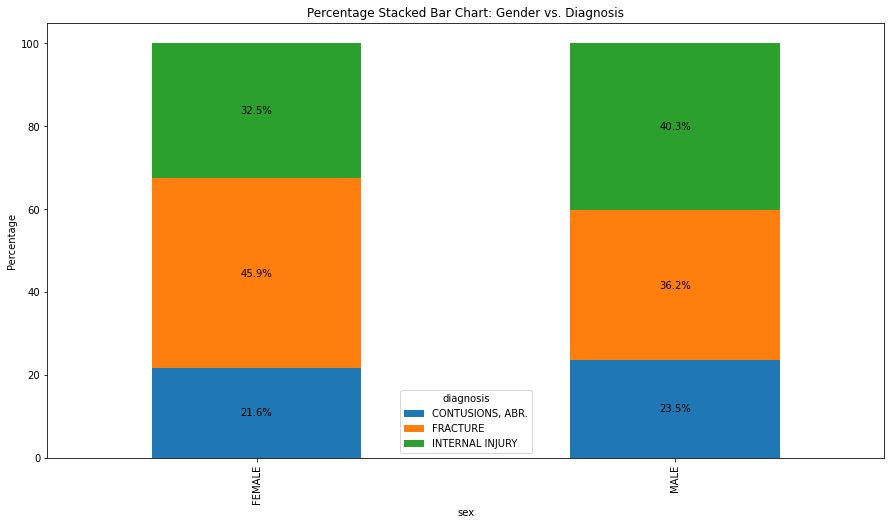

In [47]:
# Plot the percentage stacked bar chart
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(15, 8))

plt.xlabel('Sex')
plt.ylabel('Percentage')
plt.title('Percentage Stacked Bar Chart: Gender vs. Diagnosis')

# Add data labels to each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center')

- ##### Insights on gender-specific injury patterns:

The data reveals gender-specific patterns in the types of injuries diagnosed after falls. These differences highlight the importance of considering gender as a factor in understanding and addressing specific health outcomes.

Higher Incidence of Internal Injury in Males: The higher occurrence of internal injury diagnoses in males suggests that men may be more susceptible to injuries affecting internal organs following falls. This finding may be indicative of gender-related physiological differences or variations in injury mechanisms.

Contusion and Auditory Brainstem Response (ABR) in Males: The prevalence of contusion and auditory brainstem response (ABR) diagnoses in males implies that men are more likely to experience bruises or minor injuries and may also be at greater risk of auditory or neurological issues following falls.

Fractures More Common in Females: The observation that fractures are diagnosed more frequently in females suggests that women may face a higher risk of bone fractures during falls. This could be influenced by factors such as bone density, physical activity, or age-related changes affecting bone health.

##### Racial Factors (Race vs Diagnosis)

This compares the races against the top three diagnosis

In [45]:
# Calculate the proportions of each diagnosis by race
diagnosis_by_race = decoded_data_filtered_2.groupby(['race', 'diagnosis']).size() / decoded_data_filtered_2.groupby('race').size()

# Reset the index for the proportions
diagnosis_by_race = diagnosis_by_race.reset_index(name = 'Proportion')

# Pivot the data to create a percentage stacked bar chart
pivot_table_2 = diagnosis_by_race.pivot(index = 'race', columns = 'diagnosis', values = 'Proportion')

# Normalize the data to percentages (multiply by 100)
pivot_table_2 *= 100

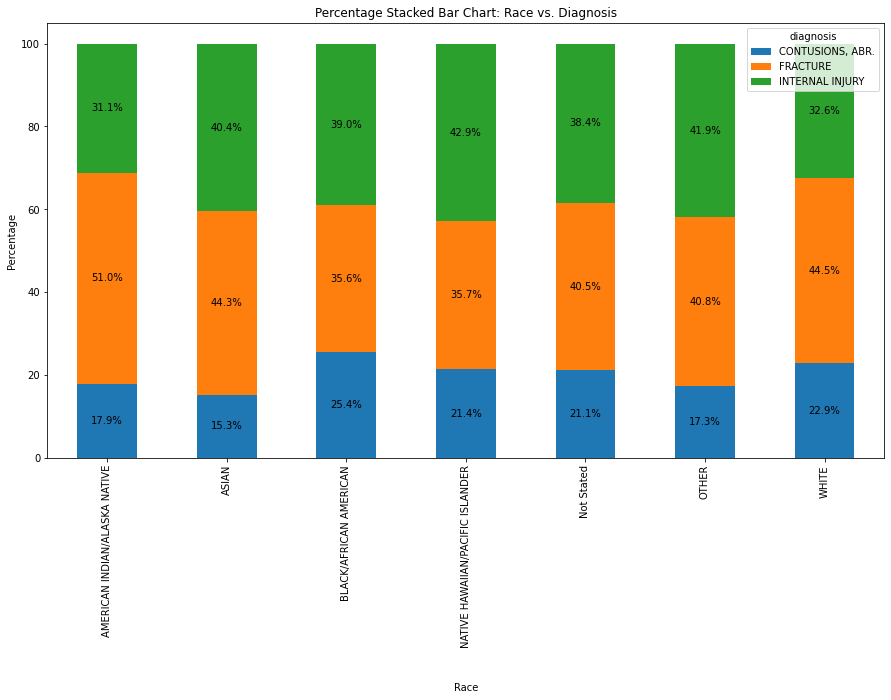

In [67]:
#Plot the percentage stacked bar chart
ax = pivot_table_2.plot(kind = 'bar', stacked = True, figsize = (15, 8))

# Add labels and a title
plt.xlabel('Race', labelpad = 35)
plt.ylabel('Percentage')
plt.title('Percentage Stacked Bar Chart: Race vs. Diagnosis')

# Add data labels to each bar segment
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center')

- ##### Insights on racial disparities in diagnosis patterns: 

The data indicates that there are disparities in the types of diagnoses individuals receive following falls among different racial groups. These disparities may reflect variations in healthcare access, socioeconomic factors, or underlying health conditions within these populations.

Higher Occurrence of Internal Injuries in Native Hawaiian/Pacific Islander: The higher incidence of internal injury diagnoses in the Native Hawaiian/Pacific Islander group suggests that individuals from this racial background may be more susceptible to injuries affecting internal organs after falling. Further research is needed to understand the specific factors contributing to this pattern.

Contusions and Auditory Brainstem Response (ABR) in Black/African American: The prevalence of contusion and auditory brainstem response (ABR) diagnoses in the Black/African American population may indicate that falls in this racial group not only result in physical injuries (contusions) but may also have neurological or auditory implications (ABR). This finding underscores the need for comprehensive assessments and care for fall-related injuries in this demographic.

Fractures More Common in American Indian/Alaska Native: The observation that fractures are diagnosed more frequently in the American Indian/Alaska Native population suggests that individuals from this racial background may be at a higher risk of bone fractures following falls. Factors contributing to this risk may include variations in bone health, activity levels, or other sociocultural factors.

### ALCOHOL VS DIAGNOSIS

In [ ]:
top_10_diagnosis = decoded_data['diagnosis'].value_counts().head(10).index
decoded_data_filtered = decoded_data[decoded_data['diagnosis'].isin(top_10_diagnosis)]
plt.figure(figsize=(14, 6))
sns.countplot(data=decoded_data_filtered, x='diagnosis', hue='alcohol')
plt.title('Top 10 Diagnosis Count by alcohol')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

most of the falls are obviously not caused by alcohol

### DRUGS VS DIAGNOSIS

In [ ]:
top_10_diagnosis = decoded_data['diagnosis'].value_counts().head(10).index
decoded_data_filtered = decoded_data[decoded_data['diagnosis'].isin(top_10_diagnosis)]
plt.figure(figsize=(14, 6))
sns.countplot(data=decoded_data_filtered, x='diagnosis', hue='drug')
plt.title('Top 10 Diagnosis Count by drug')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Most of the falls are not caused by Drugs as well

##### Environmental Factors 1 (Location vs Diagnosis)

### LOCATION VS DIAGNOSIS

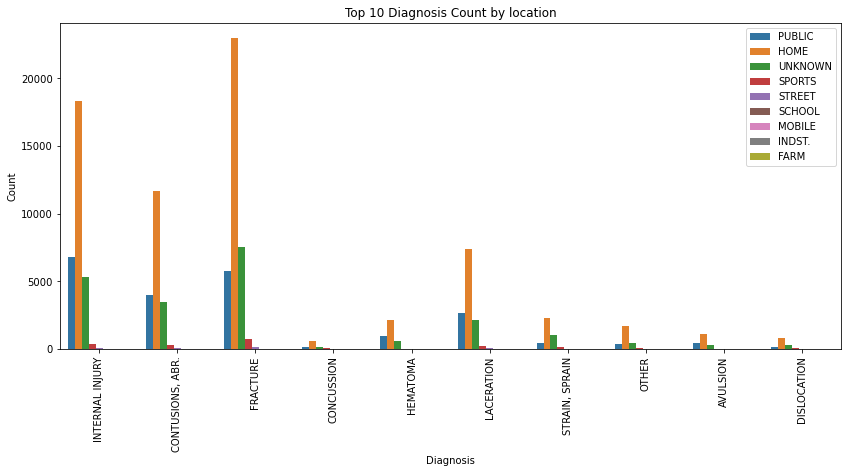

In [70]:
plt.figure(figsize=(14, 6))

sns.countplot(data = decoded_data_filtered, x = 'diagnosis', hue = 'location')

plt.title('Top 10 Diagnosis Count by location')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

plt.legend(loc = 'upper right')
plt.xticks(rotation=90);

In [72]:
decoded_data.columns

Index(['cpsc_case_number', 'narrative', 'treatment_date', 'age', 'sex', 'race',
       'other_race', 'hispanic', 'diagnosis', 'other_diagnosis', 'diagnosis_2',
       'other_diagnosis_2', 'body_part', 'body_part_2', 'disposition',
       'location', 'fire_involvement', 'alcohol', 'drug', 'product_1',
       'product_2', 'product_3', 'age_group'],
      dtype='object')

- ##### Insights on fall diagnosis by location

The observation that most falls occur at home, unknown locations, and in public areas provides valuable insights into fall prevention and safety measures. Here are insights and potential solutions based on this observation:

Home as a Common Location: The fact that a significant number of falls occur at home underscores the importance of home safety for individuals of all ages, particularly for older adults who may spend a substantial amount of time at home. This highlights the need to encourage home safety assessments, particularly for older adults, to identify and address potential fall hazards at home. This may include removing tripping hazards, improving lighting, installing handrails, and making bathrooms more accessible.

Public Spaces: Falls in public areas highlight the need for public safety measures and awareness campaigns to reduce the risk of falls in crowded places.

Unknown Locations: The "unknown location" category may indicate that some falls happen in unmonitored or less-traveled areas, making it challenging to identify and respond to these incidents promptly. A solution can be for older adults to get guides which can help them navigate unknown locations

In [73]:
decoded_data[['diagnosis', 'disposition']]

,diagnosis,disposition
0,INTERNAL INJURY,TREATED AND ADMITTED/HOSPITALIZED
1,INTERNAL INJURY,TREATED AND ADMITTED/HOSPITALIZED
2,"CONTUSIONS, ABR.",TREATED AND ADMITTED/HOSPITALIZED
3,FRACTURE,TREATED/EXAMINED AND RELEASED
4,FRACTURE,TREATED/EXAMINED AND RELEASED
...,...,...
115123,FRACTURE,TREATED AND ADMITTED/HOSPITALIZED
115124,FRACTURE,TREATED AND ADMITTED/HOSPITALIZED
115125,"STRAIN, SPRAIN",TREATED/EXAMINED AND RELEASED
115126,INTERNAL INJURY,TREATED/EXAMINED AND RELEASED


##### Environmental Factors 2 (Location vs Disposition)

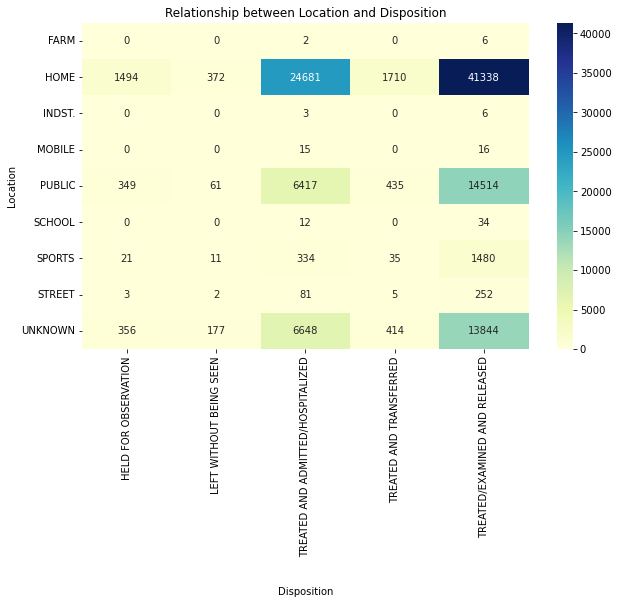

In [77]:
# Visualize the relationship between location and disposition using a heatmap
plt.figure(figsize=(10, 6))

location_disposition_cross_tab = pd.crosstab(decoded_data['location'], decoded_data['disposition'])
sns.heatmap(location_disposition_cross_tab, annot = True, fmt = 'd', cmap = 'YlGnBu')

plt.title('Relationship between Location and Disposition')
plt.xlabel('Disposition', labelpad = 30)
plt.ylabel('Location');

- ##### Insights on fall disposition by location

Falls at home are more common but result in a mix of treatment outcomes: a significant number of individuals are treated and released, while a substantial number require hospitalization, but the **"treated and transferred"** and **"left without being seen"** caught our attention.. why??

- #### Extra Insights on the "treated and transferred" and "left without being seen" dispositions

### TREATED AND TRANSFERRED


finding that some individuals were "treated and transferred" can have several implications and interpretations. Here are some possible explanations:

1. **Severity of Condition**: Individuals who were "treated and transferred" may have had medical conditions or injuries that required immediate treatment in one healthcare facility but needed specialized care or further evaluation at another facility. This suggests that their conditions were of a moderate to high severity.

2. **Availability of Specialized Services**: The initial healthcare facility where they were treated might not have had the specialized equipment, expertise, or resources needed to fully address their medical condition. Therefore, they were transferred to a different facility where such resources were available.

3. **Hospital-to-Hospital Transfer**: It could mean that patients were initially brought to a general hospital, but their condition required treatment at a specialized hospital or trauma center. These transfers are common for cases like severe trauma, stroke, or cardiac events.

4. **Interfacility Transfer**: In some cases, patients might be transferred from one healthcare facility to another within a healthcare network for continuity of care or access to specialized services like surgery or intensive care.

5. **Insurance or Coverage Considerations**: The choice to "treat and transfer" might also be influenced by insurance coverage or the patient's financial situation. Some treatments might be initiated at one facility to stabilize the patient before they are transferred to a different facility that is in-network or covered by their insurance.

Incorporating this insight into this analysis allows for a more comprehensive understanding of the healthcare landscape, patient outcomes, and the factors that influence medical decision-making. It helps to assess the effectiveness and efficiency of the healthcare system and can guide improvements in patient care and resource allocation.


### LEFT WITHOUT BEING SEEN

When conducting a bivariate analysis of health data columns like "disposition" and "diagnosis" and finding that some individuals "left without being seen," it can have several possible interpretations and implications:

1. **Patient Discontent**: Patients may have left without being seen due to dissatisfaction with the healthcare facility, long wait times, or perceived poor quality of care. This could indicate issues with patient experience and satisfaction.

2. **Walk-Outs**: "Left without being seen" often refers to patients who arrived at a healthcare facility (such as an emergency department) but left before receiving any medical evaluation or treatment. This might happen if they felt their condition improved, they couldn't wait any longer, or they thought their condition was not serious.

3. **Resource Constraints**: Healthcare facilities, particularly emergency departments, may face resource constraints, leading to long wait times and the inability to see all patients promptly. Some patients may leave due to these resource limitations.

4. **Urgency Assessment**: Patients who "left without being seen" may have initially perceived their condition as urgent but later reconsidered or received advice from others that their condition was not severe. This indicates changes in the perceived urgency of their health issues.


 **Legal and Ethical Considerations**: Healthcare professionals have legal and ethical obligations to ensure that patients receive appropriate care. "Left without being seen" cases raise questions about whether these obligations were met.

To fully understand the meaning and implications of patients leaving without being seen, it's essential to investigate the specific circumstances, including the diagnosis or presenting complaints of these patients, the timing of their departure, and any factors contributing to their decision. Such an analysis can help healthcare facilities identify opportunities for improvement in patient care, satisfaction, and operational efficiency. Additionally, it can lead to strategies for reducing patient walk-outs and ensuring that patients receive the care they need in a timely and appropriate manner.


The top reason is PATIENT DISCONTENT
Patient discontent in the healthcare sector can have significant implications for both patients and healthcare providers. Addressing patient discontent is crucial to improving the quality of care, patient experience, and overall healthcare outcomes. Here are some implications of patient discontent and strategies to tackle it:

**Implications of Patient Leaving without being seen:**

1. **Negative Patient Outcomes**: Discontented patients may delay seeking medical care, follow-up appointments, or necessary treatments, which can lead to worsened health conditions and outcomes.

2. **Reduced Trust**: Dissatisfied patients may lose trust in healthcare providers and institutions, making them less likely to adhere to medical advice or recommendations.

3. **Impact on Reputation**: Negative patient experiences can damage the reputation of healthcare facilities and healthcare providers, affecting their ability to attract and retain patients.

4. **Decreased Patient Compliance**: Discontent can result in decreased patient compliance with prescribed medications, treatment plans, and lifestyle recommendations.

5. **Litigation Risk**: Unhappy patients are more likely to consider legal action in cases of perceived medical malpractice or negligence, leading to increased legal risks for healthcare providers.

6. **Decreased Patient Retention**: Patients who are dissatisfied with their healthcare experience may seek care elsewhere, leading to a loss of patient retention and revenue for healthcare facilities.

**Strategies to Tackle Patient Leaving without being seen:**

1. **Improve Communication**: Effective communication between healthcare providers and patients is essential. Encourage open and empathetic communication, active listening, and clear explanations of diagnoses, treatment options, and expectations.

2. **Enhance Patient-Centered Care**: Shift the focus to patient-centered care, where patients are actively involved in decision-making regarding their health and treatment plans. Involve patients in care discussions and respect their preferences.

3. **Reduce Wait Times**: Implement strategies to reduce waiting times in healthcare facilities, such as appointment scheduling improvements, efficient patient flow, and optimized resource allocation.

4. **Enhance Staff Training**: Provide healthcare staff with training in patient communication, empathy, and cultural competence to ensure positive patient interactions.

5. **Quality Improvement Initiatives**: Continuously monitor and assess the quality of care through patient satisfaction surveys, feedback mechanisms, and performance evaluations. Use data to identify areas for improvement.

6. **Patient Advocacy Programs**: Establish patient advocacy programs to assist patients in navigating the healthcare system, addressing concerns, and ensuring their needs are met.

7. **Transparency**: Be transparent about healthcare costs, treatment options, and potential risks. Patients appreciate transparency in billing and treatment decisions.

8. **Complaint Resolution**: Develop clear and efficient mechanisms for addressing patient complaints and grievances. Ensure that patients know how to voice their concerns and that their feedback is taken seriously.

9. **Staff Well-Being**: Recognize that healthcare staff well-being is closely tied to patient satisfaction. Support and engage healthcare providers to prevent burnout and maintain a positive work environment.

10. **Technology Integration**: Leverage technology to improve patient experiences, such as online appointment scheduling, telehealth options, and electronic health records for easy access to medical information.

11. **Cultural Competency**: Train healthcare providers to be culturally competent and sensitive to the diverse needs and backgrounds of patients.

12. **Patient Education**: Empower patients with information about their health conditions and treatment plans. Ensure they understand their role in managing their health.

13. **Continuous Feedback Loop**: Establish a continuous feedback loop with patients to gather input and make improvements based on their suggestions and concerns.

Addressing patient discontent is an ongoing process that requires a commitment to patient-centered care, quality improvement, and a culture of empathy and responsiveness within the healthcare sector. By taking proactive steps to enhance patient satisfaction and address patient concerns, healthcare providers and institutions can improve patient outcomes and maintain their reputation.

### ALCOHOL VS DIAGNOSIS

In [ ]:
top_10_diagnosis = decoded_data['diagnosis'].value_counts().head(10).index
decoded_data_filtered = decoded_data[decoded_data['diagnosis'].isin(top_10_diagnosis)]
plt.figure(figsize=(14, 6))
sns.countplot(data=decoded_data_filtered, x='diagnosis', hue='alcohol')
plt.title('Top 10 Diagnosis Count by alcohol')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

most of the falls are obviously not caused by alcohol

### DRUGS VS DIAGNOSIS

In [ ]:
top_10_diagnosis = decoded_data['diagnosis'].value_counts().head(10).index
decoded_data_filtered = decoded_data[decoded_data['diagnosis'].isin(top_10_diagnosis)]
plt.figure(figsize=(14, 6))
sns.countplot(data=decoded_data_filtered, x='diagnosis', hue='drug')
plt.title('Top 10 Diagnosis Count by drug')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Most of the falls are not caused by Drugs as well

## To identify the common circumstances or activities during which falls occur among older adults 

In [ ]:
decoded_data['narrative'] = decoded_data['narrative'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

sentences = decoded_data['narrative'].dropna().str.replace(',', '').str.replace(':', '').str.replace('.', '')

# Tokenize the sentences into unigrams
unigrams = [word_tokenize(sentence) for sentence in sentences if len(sentence) >= 4]

# Flatten the list of unigrams
unigrams = [word for sublist in unigrams for word in sublist if len(word) >= 4]

# Count the frequency of each unigram
unigram_counts = Counter(unigrams)

#Get the top 15 most common unigrams and their counts
top_n = 15
most_common_unigrams = unigram_counts.most_common(top_n)
common_unigrams, counts = zip(*most_common_unigrams)

# Create a bar chart to visualize unigram frequencies
plt.figure(figsize=(10, 6))
plt.barh(common_unigrams, counts)
plt.xlabel('Frequency')
plt.ylabel('Unigrams')
plt.title(f'Top {top_n} Most Common Unigrams')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most common at the top
plt.show()


## BIGRAMS

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk import bigrams
decoded_data['narrative'] = decoded_data['narrative'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

sentences = decoded_data['narrative'].dropna().str.replace(',', '').str.replace(':', '').str.replace('.', '')

# Initialize NLTK's stop words
stop_words = set(stopwords.words('english'))

# Initialize a list to store preprocessed bigrams
preprocessed_bigrams = []

for sentence in sentences:
    # Tokenize the sentence
    tokens = word_tokenize(sentence)
   
    
    # Convert to lowercase, remove punctuation, and remove stop words
    clean_tokens = [word.lower() for word in tokens if word.isalpha() and len(word) >= 4  not in stop_words]
    
    # Create bigrams from the clean tokens
    bigrams_list = list(bigrams(clean_tokens))
    
    # Append the preprocessed bigrams to the list
    preprocessed_bigrams.extend(bigrams_list)

# Count the frequency of each bigram
bigram_counts = Counter(preprocessed_bigrams)

# Get the top 15 most common bigrams and their counts
top_15_bigrams = bigram_counts.most_common(15)
bigram_labels, bigram_counts = zip(*top_15_bigrams)

# Create a bar chart to visualize bigram frequencies
plt.figure(figsize=(10, 8))
plt.barh(range(len(bigram_labels)), bigram_counts)
plt.yticks(range(len(bigram_labels)), bigram_labels)
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 15 Most Common Bigrams')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most common at the top
plt.show()


### The bigrams extracted provide insights into the reasons older adults fall and suggest potential solutions for fall prevention. Let's analyze each bigram:

1. **Head Injury**: The presence of "head injury" indicates that head injuries are a significant outcome of falls among older adults. It's essential to focus on strategies to prevent head injuries, such as using protective headgear and implementing fall prevention programs.

2. **Fell Floor**: "Fell floor" suggests that falls often result in individuals landing on the floor. This emphasizes the importance of strategies to minimize the impact of falls, including improving flooring materials to reduce injury risk.

3. **Closed Head**: "Closed head" could refer to injuries where the skull is not fractured but may still result in concussions or other head injuries. Preventive measures may include education on recognizing the signs of head injuries and seeking medical attention.

4. **Hitting Head**: Falls that lead to "hitting head" indicate a potential problem with balance or coordination. Solutions may involve balance exercises, regular vision check-ups, and environmental modifications to reduce hazards.

5. **Nursing Home**: The mention of "nursing home" suggests that falls occur in care facilities. Solutions may involve improved staff training, fall risk assessments, and environmental modifications in nursing homes.

6. **Tripped Over**: "Tripped over" highlights the role of tripping hazards in falls. Reducing tripping hazards, such as clutter and loose rugs, can help prevent falls.

7. **Striking Head**: Similar to "hitting head," this bigram points to falls leading to head injuries. Strategies to reduce head injuries are relevant here.

8. **Lost Balance**: The phrase "lost balance" indicates that balance issues may contribute to falls. Balance training exercises and medical evaluations to identify underlying causes can be beneficial.

9. **Fell Down**: "Fell down" is a straightforward representation of falls. Fall prevention strategies should be implemented broadly, including home safety measures and regular exercise.

10. **Floor Home**: "Floor home" suggests that falls often occur at home. Home safety assessments and modifications are essential to reduce fall risks.

Based on these insights, here are some potential solutions for fall prevention among older adults:

- **Fall Risk Assessments**: Conduct regular fall risk assessments for older adults, taking into account their health conditions, mobility, and living environment.

- **Home Safety Modifications**: Promote home safety assessments and modifications, such as installing handrails, improving lighting, and removing tripping hazards.

- **Balance and Strength Training**: Encourage older adults to engage in balance and strength training exercises to improve their physical stability and reduce the risk of falling.

- **Medication Management**: Review and manage medications that may cause dizziness or affect balance, consulting with healthcare professionals as needed.

- **Use of Mobility Aids**: Provide and educate older adults on the appropriate use of mobility aids such as walkers or canes.

- **Regular Health Checkups**: Encourage older adults to have regular checkups with healthcare providers to address any underlying health issues that may contribute to falls.

- **Educational Programs**: Offer educational programs to raise awareness about fall prevention, including information on recognizing fall risks and taking preventive measures.

- **Environmental Modifications in Nursing Homes**: Improve the safety of nursing homes by implementing environmental modifications and staff training programs.

- **Protective Headgear**: For older adults at risk of head injuries due to falls, consider the use of protective headgear, such as helmets or head protection.

- **Regular Vision Exams**: Encourage older adults to have regular vision exams to ensure proper vision, which is crucial for balance and coordination.

Implementing a combination of these solutions tailored to individual needs and circumstances can significantly reduce the risk of falls among older adults and enhance their overall safety and well-being. Additionally, fostering a supportive and vigilant community or caregiver network can further contribute to fall prevention.